In [1]:
import warnings
warnings.filterwarnings("ignore")

import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import functools
import nltk
import xgboost as xgb
import re
import seaborn as sn
import pandas as pd
import time 

from emoji import UNICODE_EMOJI

import sklearn
from sklearn.model_selection import train_test_split, cross_validate # for splitting data into train and test samples
from sklearn.svm import SVC, LinearSVC # for Support Vector Classification baseline model
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # for model evaluation metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold



from difflib import get_close_matches

contents = []
with open("rumour-annotation-2_annotations.json", 'rb') as j:
     contents.append(json.loads(j.read()))

contents2 = []
with open("rumour-annotation-3_annotations.json", 'rb') as j:
     contents2.append(json.loads(j.read()))

contents3 = []
with open("rumour-annotation_annotations.json", 'rb') as j:
     contents3.append(json.loads(j.read()))

contents4 = []
with open("rumour-annotation-4_annotations.json", 'rb') as j:
     contents4.append(json.loads(j.read()))


In [2]:
df = pd.read_csv("DutchTwitterData.csv", sep="\t").drop('Unnamed: 0',axis=1)

columns = ["followers_count",
          "tweet_count",
          "question_marks",
          "verified",
          "accountlife",
          "followers_ratio",
          "exclamation_marks",
          "capital letters",
          "retweet_count",
          "hashtags",
          "following",
          "text length",
          "listed_count",
          "emoticons",
          "like_count",
          "time_after_posting",
          "activity",
          "text",
          "hashtag",
          "upsample_group",
          "label"]

In [3]:
df

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,...,text length,listed_count,emoticons,like_count,time_after_posting,activity,text,hashtag,upsample_group,label
0,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1.0
1,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,...,0.146830,0.000000,0.0,0.0,0.910891,0.981275,#nosjournaal #buitenhof #eenvandaag #op1 @deni...,#jinek,-1#jinek,-1.0
2,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1.0
3,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,...,0.142380,0.004799,0.0,0.0,0.155891,0.981256,RT @Quadenmakelaars: https://t.co/KO6Aw33rtg\n...,#jinek,-1#jinek,-1.0
4,0.000053,0.009421,0.0,0.0,0.002838,0.000088,0.0,0.204461,0.000000,1.0,...,0.322581,0.000800,0.0,0.0,0.648938,0.981257,#buitenhof\n\nGaaaaaaaaf land NL\n\n#rutte @Mi...,#jinek,-1#jinek,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494074,0.0,0.0,0.0,0.0,0.993064,0.000000,0.0,0.049566,0.000000,1.0,...,0.144605,0.000000,0.0,0.0,1.000000,0.006306,Slim Beleggen - Weekend TV http://bit.ly/deDzP...,#inflatie,-1#inflatie,-1.0
494075,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.092325,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1.0
494076,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,...,0.092325,0.000000,0.0,0.0,1.000000,0.004122,Goud worstelt zich terug boven 1000 dollar! ht...,#inflatie,-1#inflatie,-1.0
494077,0.0,0.0,0.0,0.0,0.997605,0.000000,0.0,0.008261,0.000000,1.0,...,0.149055,0.000000,0.0,0.0,1.000000,0.002177,@desmodus Lastig. En het erge vind ik dus dat ...,#inflatie,-1#inflatie,-1.0


In [5]:
df[columns[:-4]]

,followers_count,tweet_count,question_marks,verified,accountlife,followers_ratio,exclamation_marks,capital letters,retweet_count,hashtags,following,text length,listed_count,emoticons,like_count,time_after_posting,activity
0,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,0.000049,0.146830,0.000000,0.0,0.0,0.910891,0.981275
1,0.000016,0.002909,0.0,0.0,0.002835,0.000088,0.0,0.028914,0.000000,1.0,0.000049,0.146830,0.000000,0.0,0.0,0.910891,0.981275
2,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,0.006059,0.142380,0.004799,0.0,0.0,0.155891,0.981256
3,0.001251,0.011679,0.0,0.0,0.002836,0.000105,0.0,0.037175,0.000327,1.0,0.006059,0.142380,0.004799,0.0,0.0,0.155891,0.981256
4,0.000053,0.009421,0.0,0.0,0.002838,0.000088,0.0,0.204461,0.000000,1.0,0.000269,0.322581,0.000800,0.0,0.0,0.648938,0.981257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494074,0.0,0.0,0.0,0.0,0.993064,0.000000,0.0,0.049566,0.000000,1.0,0.000000,0.144605,0.000000,0.0,0.0,1.000000,0.006306
494075,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,0.000000,0.092325,0.000000,0.0,0.0,1.000000,0.004122
494076,0.0,0.0,0.0,0.0,0.995466,0.000000,1.0,0.016522,0.000000,1.0,0.000000,0.092325,0.000000,0.0,0.0,1.000000,0.004122
494077,0.0,0.0,0.0,0.0,0.997605,0.000000,0.0,0.008261,0.000000,1.0,0.000000,0.149055,0.000000,0.0,0.0,1.000000,0.002177


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       485
           1       0.98      0.95      0.97       337

    accuracy                           0.97       822
   macro avg       0.98      0.97      0.97       822
weighted avg       0.97      0.97      0.97       822

0.9711064884211815


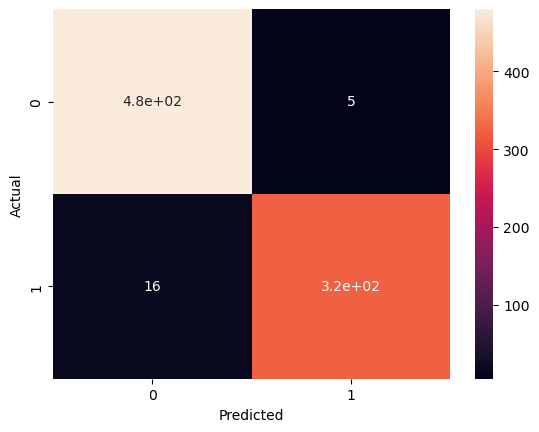

In [62]:
df_labeled=df[df["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.2)

df_unlabeled = df[df["label"]==-1]
df_train = df_train.append(df_unlabeled)

X_baseline=df_train[columns[:-4]].to_numpy()
y_baseline=df_train['label'].values

# Put test data into an array
X_test=df_test[columns[:-4]].to_numpy()
y_test=df_test['label'].values

#model = MultinomialNB()
model = xgb.XGBClassifier(objective="binary:logistic")
#model = model = SVC(kernel='linear',
#                         probability=True, 
#                         C=1.0, 
#                         max_iter = 1000,
#                         gamma='scale',
#                    )

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=False # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_baseline, y_baseline)
#AUC


# accuracy, precision, recall, F1-score
print(classification_report(y_test, clf_ST.predict(X_test)))
print(roc_auc_score(y_test, clf_ST.predict(X_test)))
#confusion matrix
cm = confusion_matrix(y_test, clf_ST.predict(X_test))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

0.8261054234493866


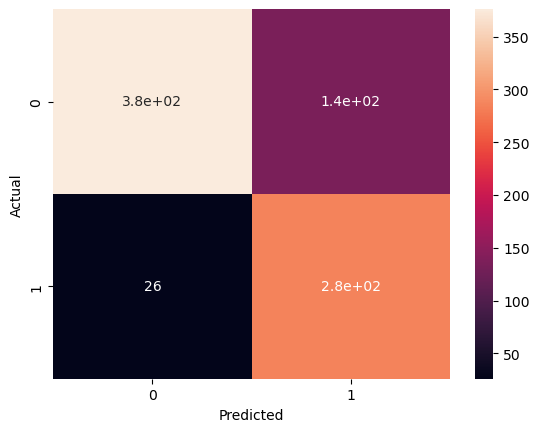

In [60]:
#"normal" model without unlabeled data

df_labeled=df[df["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.2)

X_baseline=df_train[columns[:-4]]
y_baseline=df_train['label'].values

# Put test data into an array
X_test=df_test[columns[:-4]]
y_test=df_test['label'].values


########## Step 2 - Model Fitting ########## 
#Select a model 
#model = MultinomialNB()
#model = xgb.XGBClassifier(objective="binary:logistic")
model = model = SVC(kernel='linear',
                         probability=True,
                         C=1.0,
                         max_iter = 1000,
                         gamma='scale',
                    )
model.fit(X_baseline, y_baseline)

print(roc_auc_score(y_test, model.predict(X_test)))

#confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

0.933356681843198


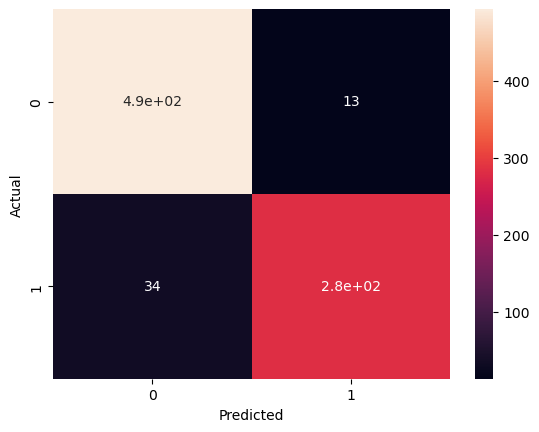

In [66]:

#for i in range(0,10):
#self training, only two most important features

df_labeled=df[df["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.2)

df_unlabeled = df[df["label"]==-1]
df_train = df_train.append(df_unlabeled)

X_baseline=df_train[["exclamation_marks", "retweet_count"]]
y_baseline=df_train['label'].values

# Put test data into an array
X_test=df_test[["exclamation_marks", "retweet_count"]]
y_test=df_test['label'].values

########## Step 2 - Model Fitting ########## 
#Select a model 
#model = MultinomialNB()
model = xgb.XGBClassifier(objective="binary:logistic")
#model = model = SVC(kernel='linear',
#                         probability=True,
#                         C=1.0,
#                         max_iter = 1000,
#                         gamma='scale', 
#                    )

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=False # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_baseline, y_baseline)



#accuracy, precision, recall, F1-score
#print(classification_report(y_test, clf_ST.predict(X_test.values)))
#AUC
print(roc_auc_score(y_test, clf_ST.predict(X_test.values)))

#confusion matrix
cm = confusion_matrix(y_test, clf_ST.predict(X_test.values))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
#only features that would have been known early on 

earlycolumns = [#"followers",
          "tweet_count",
          "question_marks",
          "verified",
          "accountlife",
#          "followers_count",
          "exclamation_marks",
          "capital letters",
#          "retweet_count",
          "hashtags",
          "following",
          "text length",
#          "listed_count",
          "emoticons",
#          "like_count",
          "time_after_posting",
          "activity",
          "label"]

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       482
           1       0.97      0.95      0.96       340

    accuracy                           0.97       822
   macro avg       0.97      0.96      0.97       822
weighted avg       0.97      0.97      0.97       822

0.9646265560165974


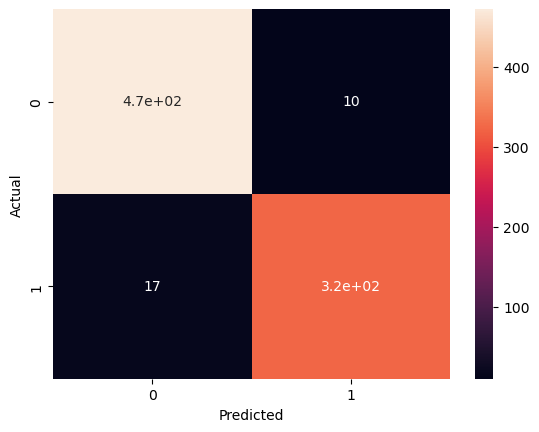

In [36]:
df_labeled=df[df["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.2)

df_unlabeled = df[df["label"]==-1]
df_train = df_train.append(df_unlabeled)

X_baseline=df_train[earlycolumns[:-4]]
y_baseline=df_train['label'].values

# Put test data into an array
X_test=df_test[earlycolumns[:-4]]
y_test=df_test['label'].values

########## Step 2 - Model Fitting ########## 
#Select a model 
#model = MultinomialNB()
model = xgb.XGBClassifier(objective="binary:logistic")
# model = SVC(kernel='linear',
#                          probability=True,
#                          C=1.0,
#                          max_iter = 1000,
#                          gamma='scale',
#                     )

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=False # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_baseline, y_baseline)



#accuracy, precision, recall, F1-score
print(classification_report(y_test, clf_ST.predict(X_test.values)))
#AUC
print(roc_auc_score(y_test, clf_ST.predict(X_test.values)))

cm = confusion_matrix(y_test, clf_ST.predict(X_test.values))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

train: vleestaks , inflatie
test: jinek
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       399
           1       0.15      0.18      0.16       147

    accuracy                           0.50       546
   macro avg       0.41      0.40      0.40       546
weighted avg       0.53      0.50      0.51       546

0.39760114572144645


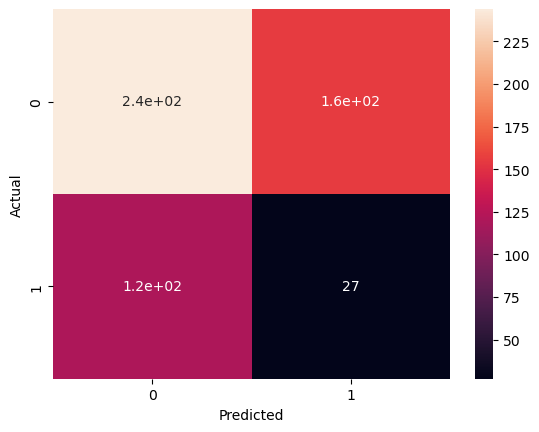

------
train: jinek , inflatie
test: vleestaks
              precision    recall  f1-score   support

           0       0.33      0.01      0.02      1644
           1       0.01      0.32      0.02        60

    accuracy                           0.02      1704
   macro avg       0.17      0.16      0.02      1704
weighted avg       0.32      0.02      0.02      1704

0.16441605839416057


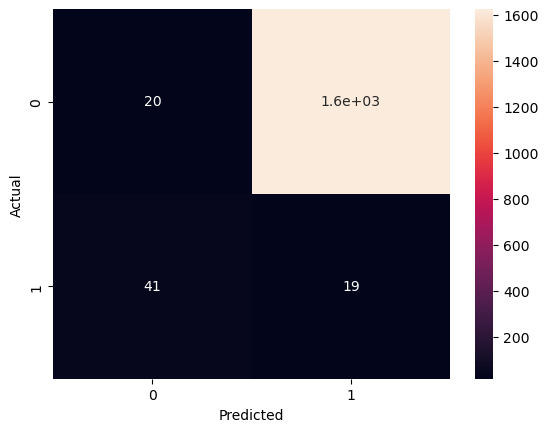

------
train: jinek , vleestaks
test: inflatie
              precision    recall  f1-score   support

           0       0.22      0.87      0.36       443
           1       0.55      0.05      0.09      1414

    accuracy                           0.25      1857
   macro avg       0.39      0.46      0.22      1857
weighted avg       0.47      0.25      0.15      1857

0.4600647826794934


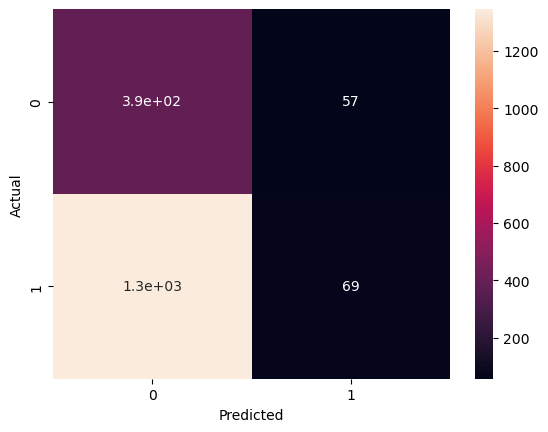

------


In [29]:
# #normal classification except use cross validation to train on all hashtags - 1  each iteration 
kf = KFold(n_splits=3, shuffle=False)

df_j = df[df["hashtag"]=="#jinek"]
df_v = df[df["hashtag"]=="#vleestaks"]
df_i = df[df["hashtag"]=="#inflatie"]
dfs = [df_j, df_v, df_i]
names = ["jinek", "vleestaks", "inflatie"]

model = xgb.XGBClassifier(objective="binary:logistic")
# model = SVC(kernel='linear',
#                          probability=True,
#                          C=1.0,
#                          max_iter = 1000,
#                          gamma='scale'
#            )
#model = MultinomialNB()
    
for train_index, test_index in kf.split(dfs):
    train = pd.concat([dfs[train_index[0]], dfs[train_index[1]]], ignore_index=True)
    test = dfs[test_index[0]][dfs[test_index[0]]["label"] != -1]
    
    X_train = train[columns[:-4]]
    X_test = test[columns[:-4]]
    y_train = train["label"]
    y_test = test ['label']
        

    
    # Specify Self-Training model parameters
    self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                                 threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                                 criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                                 #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                                 max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                                 verbose=False # default=False, Verbosity prints some information after each iteration
                                                )

    # Fit the model
    clf_ST = self_training_model.fit(X_train, y_train)



    #accuracy, precision, recall, F1-score
    print("train: " + str(names[train_index[0]]) + " , " + str(names[train_index[1]]))
    print("test: " + str(names[test_index[0]]))
    print(classification_report(y_test, clf_ST.predict(X_test.values)))
    print(roc_auc_score(y_test, clf_ST.predict(X_test.values)))
    cm = confusion_matrix(y_test, clf_ST.predict(X_test.values))
    sn.heatmap(cm, annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("------")    

In [31]:
context_columns = ["followers_count",
          "tweet_count",
          "verified",
          "accountlife",
          "followers_ratio",
          "retweet_count",
          "following",
          "listed_count",
          "like_count",
          "time_after_posting",
          "activity",
          "label"]

content_columns = [
          "question_marks",
          "exclamation_marks",
          "capital letters",
          "hashtags",
          "text length",
          "emoticons",
          "label"]

In [ ]:
dfcontext = df[context_columns]
dfcontent = df[content_columns]

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       498
           1       0.40      1.00      0.57       324

    accuracy                           0.40       822
   macro avg       0.70      0.51      0.29       822
weighted avg       0.76      0.40      0.24       822



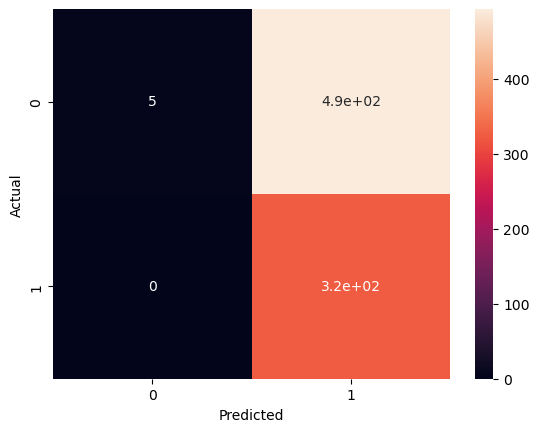

0.5050200803212852


In [44]:
df_labeled=dfcontext[dfcontext["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.2)

df_unlabeled = dfcontext[dfcontext["label"]==-1]
df_train = df_train.append(df_unlabeled)

X_baseline=df_train[context_columns[:-4]]
y_baseline=df_train['label'].values

# Put test data into an array
X_test=df_test[context_columns[:-4]]
y_test=df_test['label'].values

########## Step 2 - Model Fitting ########## 
#Select a model 
#model = MultinomialNB()
#model = xgb.XGBClassifier(objective="binary:logistic")
model = SVC(kernel='linear',
                        probability=True,
                        C=1.0,
                        max_iter = 1000,
                        gamma='scale',
                   )

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=False # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_baseline, y_baseline)



#accuracy, precision, recall, F1-score
print(classification_report(y_test, clf_ST.predict(X_test.values)))
#confusion matrix
cm = confusion_matrix(y_test, clf_ST.predict(X_test.values))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(roc_auc_score(y_test, clf_ST.predict(X_test.values)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       493
           1       0.93      0.95      0.94       329

    accuracy                           0.95       822
   macro avg       0.95      0.95      0.95       822
weighted avg       0.95      0.95      0.95       822



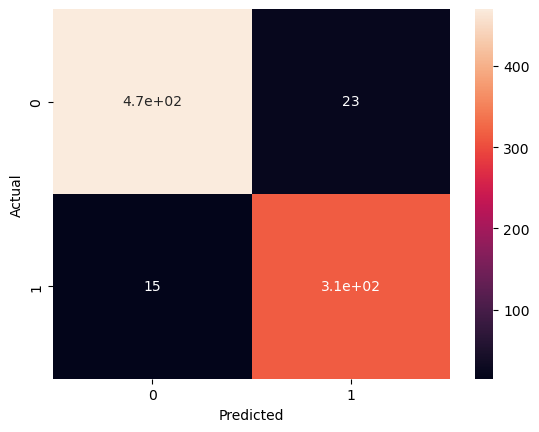

0.9538770754082998


In [48]:
df_labeled=dfcontent[dfcontent["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.2)

df_unlabeled = dfcontent[dfcontent["label"]==-1]
df_train = df_train.append(df_unlabeled)

X_baseline=df_train[content_columns[:-4]]
y_baseline=df_train['label'].values

# Put test data into an array
X_test=df_test[content_columns[:-4]]
y_test=df_test['label'].values

########## Step 2 - Model Fitting ########## 
#Select a model 
#model = MultinomialNB()
model = xgb.XGBClassifier(objective="binary:logistic")
# model = SVC(kernel='linear',
#                         probability=True,
#                         C=1.0,
#                         max_iter = 1000,
#                         gamma='scale',
#                    )

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=False # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_baseline, y_baseline)



#accuracy, precision, recall, F1-score
print(classification_report(y_test, clf_ST.predict(X_test.values)))
#confusion matrix
cm = confusion_matrix(y_test, clf_ST.predict(X_test.values))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(roc_auc_score(y_test, clf_ST.predict(X_test.values)))

In [30]:
columns_with_text = ["followers_count",
          "tweet_count",
          "question_marks",
          "verified",
          "accountlife",
          "followers_ratio",
          "exclamation_marks",
          "capital letters",
          "retweet_count",
          "hashtags",
          "following",
          "text length",
          "listed_count",
          "emoticons",
          "like_count",
          "time_after_posting",
          "activity",
          "text",
          "label"]

In [31]:
df_with_text = df[columns_with_text]

df_labeled=df_with_text[df_with_text["label"]!=-1]
df_train, df_test = train_test_split(df_labeled, test_size=0.25)

df_unlabeled = df_with_text[df_with_text["label"]==-1]
df_train = df_train.append(df_unlabeled)

df_test = df_test.reset_index()
df_train = df_train.reset_index()

In [32]:
#https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99

class BoW:
    def __init__(self):
        # Here is where we keep all words. A set for faster lookup
        self.all_words = set()
        # Two dictionaries to map word to index and back. This helps 'encoding' and 'decoding' a BoW
        self.word_to_idx= {}
        self.idx_to_word= {}
        # The total number of words is just kept to aid starting the numpy array size, but can be inferred from all_words set.
        self.total_words = 0
        
    def fit(self, document):
        """
        Fits the BoW using the data. This is used to help the BoW learn the vocabulary and word indexes.
        """
        # Just checking if its empty or not
        if type(document) != list or len(document) <1 or type(document[0]) != str:
            raise TypeError("You must pass a list of strings for fitting.")
        list_of_sentences = document
        # Now, we go through each sentence.
        for sentence in list_of_sentences:
            # Naive tokenizing. Just splitting sentence is usually not enought, but we keep it simple here.
            words = [word.lower() for word in sentence.split()]
            for word in words:
                # Add all words. Since its a set, there won't be duplicates.
                self.all_words.add(word)
        for idx, word in enumerate(self.all_words):
            # Set the mapping indexes.
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        # Set the vocab size.
        self.total_words = len(self.all_words)
        
    def transform(self, data):
        """
        Transforms the input data into the BoW model format.
        """
        # Check that the model is fit.
        if self.total_words == 0:
            raise AttributeError("You must first fit the data.")
        if type(data) == str:
            # We call the private helper function _transform_single for each input. If there's only a single sentence, we transform it here and return a single <vector>.
            transformed = self._transform_single(data.split())
        elif type(data) == list and type(data[0]) == str:
            # Now, if we have more than one sentence (a document), we'll make a matrix of stacked sentence arrays. For that we go through each sentence.
            # Create empty matrix.
            transformed = np.empty((len(data),self.total_words))
            # Iterate over all sentences - this can be parallelized.
            for row, sentence in enumerate(data):
                # Substitute each row by the sentence BoW.
                transformed[row] = self._transform_single(sentence.split())
        else:
            raise TypeError("You must pass either a string or list of strings for transformation.")
        return transformed

    def fit_transform(self, data):
        """
        Does both fitting and transforming at once.
        """
        self.fit(data)
        return self.transform(data)

    def _transform_single(self, list_of_words):
        """
        Auxiliary method for simplifying the process of transforming. Here is where the "magic" happens.
        """
        # Start a zero filled array with the size of the vocabulary.
        transformed = np.zeros(self.total_words)
        for word in list_of_words:
            # Iterate over sentence words checking if they are in the vocabulary.
            if word in self.all_words:
                word_idx = self.word_to_idx[word]
                # Change the value of that specific index, by increasing the value.
                transformed[word_idx]+=1
        return transformed          


In [33]:
test_text = [x for x in df_test["text"]]

train_text = [x for x in df_train["text"]]

In [59]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=450, stop_words='english')
bow_train = bow_vectorizer.fit_transform(train_text)

bow_train_df = pd.DataFrame(bow_train.toarray())
bow_train_df["index"] = bow_train_df.index

df_train["index"] = df_train.index

bow_train_df = pd.merge(bow_train_df, df_train).drop(["index", "text", "label"], axis=1)

In [60]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=450, stop_words='english')
bow_test = bow_vectorizer.fit_transform(test_text)
bow_test_df = pd.DataFrame(bow_test.toarray())
bow_test_df["index"] = bow_test_df.index

df_test["index"] = df_test.index
bow_test_df = pd.merge(bow_test_df, df_test).drop(["index", "text", "label"], axis=1)

In [61]:
scaler = MinMaxScaler()
scaler.fit(bow_train_df[columns_with_text[:-2]].to_numpy())
bow_train_df[columns_with_text[:-2]] = scaler.transform(bow_train_df[columns_with_text[:-2]].to_numpy())

scaler = MinMaxScaler()
scaler.fit(bow_test_df[columns_with_text[:-2]].to_numpy())
bow_test_df[columns_with_text[:-2]] = scaler.transform(bow_test_df[columns_with_text[:-2]].to_numpy())

X_baseline=bow_train_df
y_baseline=df_train['label'].values

# Put test data into an array
X_test=dataframe=bow_test_df
y_test=df_test['label'].values

              precision    recall  f1-score   support

           0       0.62      0.20      0.31       621
           1       0.40      0.81      0.54       406

    accuracy                           0.44      1027
   macro avg       0.51      0.51      0.42      1027
weighted avg       0.54      0.44      0.40      1027



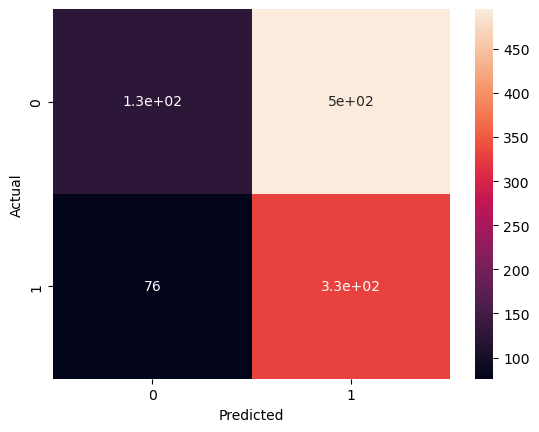

0.5078532162490184


In [62]:
########## Step 2 - Model Fitting ########## 
#Select a model 
#model = MultinomialNB()
model = xgb.XGBClassifier(objective="binary:logistic")
# model = model = SVC(kernel='linear',
#                      probability=True,
#                      C=1.0,
#                      max_iter = 1000,
#                      gamma='scale',
#                 )

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=False # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_baseline, y_baseline)



#accuracy, precision, recall, F1-score
print(classification_report(y_test, clf_ST.predict(X_test)))
#confusion matrix
cm = confusion_matrix(y_test, clf_ST.predict(X_test))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(roc_auc_score(y_test, clf_ST.predict(X_test)))

In [54]:
#normal classification except use cross validation to train on all hashtags - 1  each iteration  
#context features 

df_j = df[df["hashtag"]=="#jinek"][context_columns]
df_v = df[df["hashtag"]=="#vleestaks"][context_columns]
df_i = df[df["hashtag"]=="#inflatie"][context_columns]

train: vleestaks , inflatie
test: jinek
0.4965986394557823


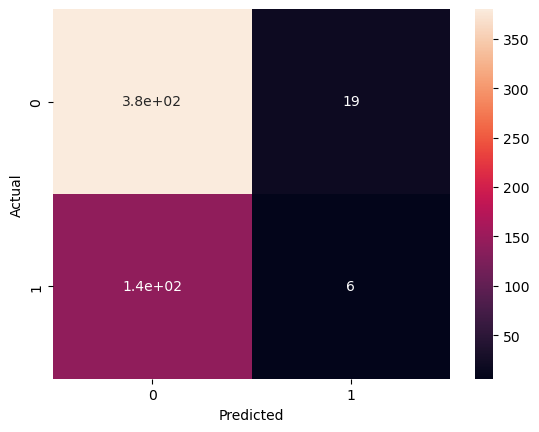

------
train: jinek , inflatie
test: vleestaks
0.5


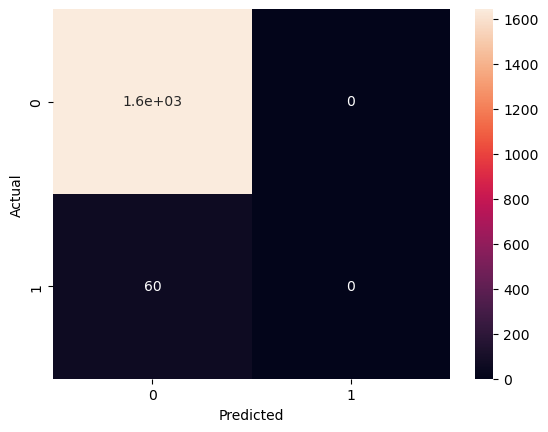

------
train: jinek , vleestaks
test: inflatie
0.5003536067892503


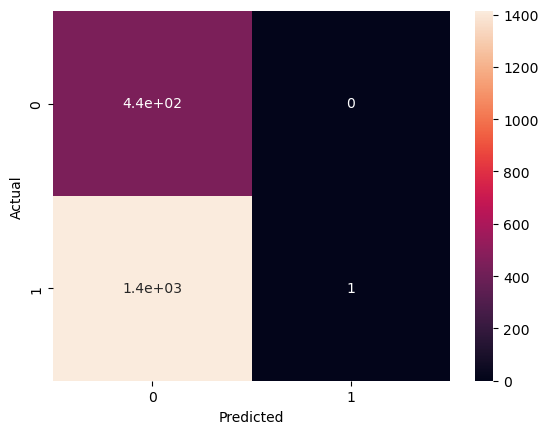

------


In [55]:
kf = KFold(n_splits=3, shuffle=False)
dfs = [df_j,df_v, df_i]
names = ["jinek","vleestaks", "inflatie"]


for train_index, test_index in kf.split(dfs):
    train = pd.concat([dfs[train_index[0]],dfs[train_index[1]]], ignore_index=True)
    test = dfs[test_index[0]][dfs[test_index[0]]["label"] != -1]
    
    X_train = train[context_columns[:-4]]
    X_test = test[context_columns[:-4]]
    y_train = train["label"].values
    y_test = test ['label'].values
        
#    model = xgb.XGBClassifier(objective="binary:logistic")
#     model = SVC(kernel='linear',
#                         probability=True,
#                         C=1.0,
#                         max_iter = 1000,
#                         gamma='scale'
#                )
    model = MultinomialNB()
    
    # Specify Self-Training model parameters
    self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                                 threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                                 criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                                 #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                                 max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                                 verbose=False # default=False, Verbosity prints some information after each iteration
                                                )

    # Fit the model
    clf_ST = self_training_model.fit(X_train, y_train)
    #print("testdata : " + str(dfs[test_index]))


    #accuracy, precision, recall, F1-score
    #print(classification_report(y_test, clf_ST.predict(X_test)))
    print("train: " + str(names[train_index[0]]) + " , " + str(names[train_index[1]]))
    print("test: " + str(names[test_index[0]]))
    print(roc_auc_score(y_test, clf_ST.predict(X_test)))
    cm = confusion_matrix(y_test, clf_ST.predict(X_test))
    sn.heatmap(cm, annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("------")    

In [56]:
#normal classification except use cross validation to train on all hashtags - 1  each iteration  
#content features

#just classifies everything as unlabelled  


df_j = df[df["hashtag"]=="#jinek"][content_columns]
df_v = df[df["hashtag"]=="#vleestaks"][content_columns]
df_i = df[df["hashtag"]=="#inflatie"][content_columns]

train: vleestaks , inflatie
test: jinek
0.4153240243465807


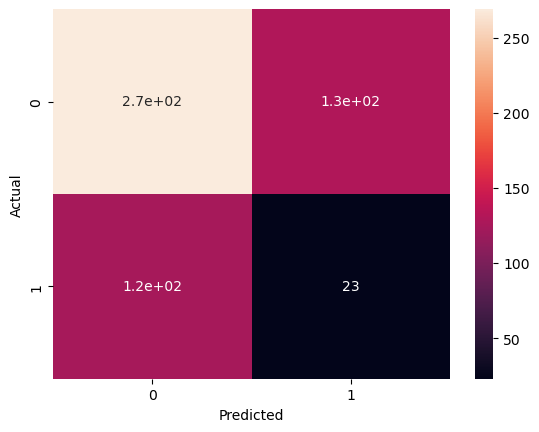

------
train: jinek , inflatie
test: vleestaks
0.4996958637469586


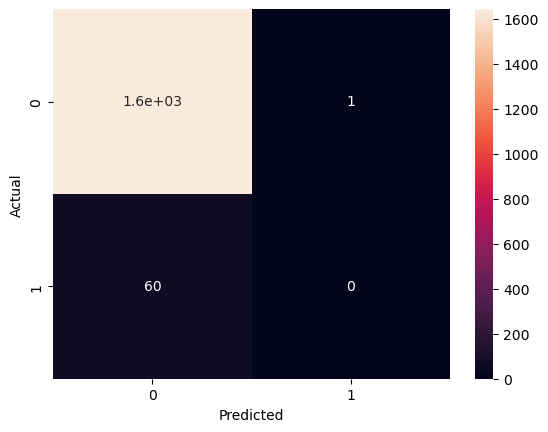

------
train: jinek , vleestaks
test: inflatie
0.5


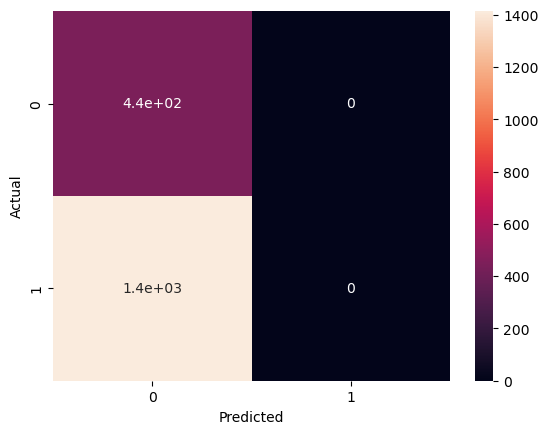

------


In [57]:
kf = KFold(n_splits=3, shuffle=False)
dfs = [df_j, df_v, df_i]
names = ["jinek", "vleestaks", "inflatie"]



for train_index, test_index in kf.split(dfs):
    train = pd.concat([dfs[train_index[0]],dfs[train_index[1]]], ignore_index=True)
    test = dfs[test_index[0]][dfs[test_index[0]]["label"] != -1]
    
    X_train = train[content_columns[:-4]]
    X_test = test[content_columns[:-4]]
    y_train = train["label"]
    y_test = test ['label']
        
#    model = xgb.XGBClassifier(objective="binary:logistic")
#     model = SVC(kernel='linear',
#                         probability=True,
#                         C=1.0,
#                         max_iter = 1000,
#                         gamma='scale',
#                )
    model = MultinomialNB()
    
    # Specify Self-Training model parameters
    self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                                 threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                                 criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                                 #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                                 max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                                 verbose=False # default=False, Verbosity prints some information after each iteration
                                                )

    # Fit the model
    clf_ST = self_training_model.fit(X_train, y_train)
    #print("testdata : " + str(dfs[test_index]))


    #accuracy, precision, recall, F1-score
    print("train: " + str(names[train_index[0]]) + " , " + str(names[train_index[1]]))
    print("test: " + str(names[test_index[0]]))
    #print(classification_report(y_test, clf_ST.predict(X_test)))
    print(roc_auc_score(y_test, clf_ST.predict(X_test)))
    cm = confusion_matrix(y_test, clf_ST.predict(X_test))
    sn.heatmap(cm, annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("------")    